<a href="https://colab.research.google.com/github/jeremysb1/enbpi_ts/blob/main/EnbPI_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble batch PIs (EnbPIs)

EnbPI is currently one of the most popular implementations of conformal prediction for time series forecasting. It has been implemented in popular open source conformal prediction libraries such as MAPIE, Amazon Fortuna, and PUNCC.

The problem this project is solving requires forecasting bike sharing demand expressed in the count of rented bikes.

In [1]:
pip install aws-fortuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.2/227.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2
  Attempting uninstall: flax
    Found existing installation: flax 0.8.4
    Uninstalling flax-0.8.4:
      Successfully uninstalled flax-0.8.4


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
pip install --upgrade git+https://github.com/google/flax.git

  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-q9rrirya
  Running command git clone --filter=blob:none --quiet https://github.com/google/flax.git /tmp/pip-req-build-q9rrirya
  Resolved https://github.com/google/flax.git to commit 5694517f6fc3201fbf490a797a4d6ce44a35528b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 8.3 MB/s eta 0:00:00
  Created wheel for flax: filename=flax-0.8.6-py3-none-any.whl size=755117 sha256=c2f3d39ef468ab21a1d90a8f717dbb79e3df39230bbd7e09a61f9c864abbf4b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-c6zq6uv8/wheels/10/42/6d/dd72bf4b2bc969d2b1851253884221d233a6c3db3eaa14fc75
Successfully built flax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.2

In [4]:
from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability

In [5]:
from sklearn.datasets import fetch_openml
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")

In [6]:
df = bike_sharing.frame
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [7]:
df.shape

(17379, 13)

In [8]:
df.groupby(["weekday", "hour"])["count"].mean()

weekday  hour
0        0        93.990385
         1        77.432692
         2        61.627451
         3        31.144231
         4         9.362745
                    ...    
6        19      239.932692
         20      180.865385
         21      156.000000
         22      139.663462
         23      115.855769
Name: count, Length: 168, dtype: float64

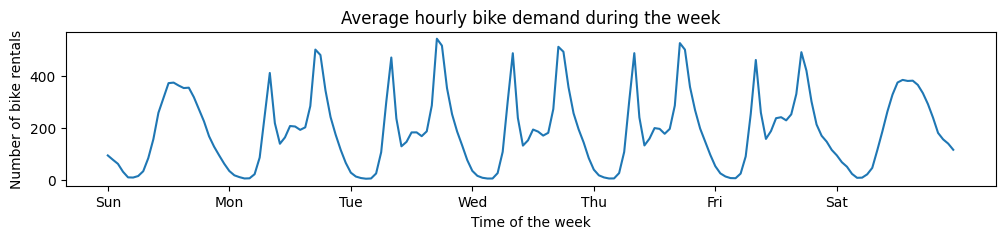

In [9]:
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [10]:
df = df.sample(500)
y = df["count"] / df["count"].max()
X = df.drop("count", axis = "columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

## Data Bootstrapping

EnbPI requires bootstrapping the data, i.e. sampling with replacement random subsets of the time series and training a model for each of these samples.

In [11]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

In [12]:
n_bs_samples = 10
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(X_train, y_train)

In [13]:
bs_indices.shape

(10, 400)

In [14]:
bs_indices

array([[220, 115, 334, ..., 214, 395,   8],
       [ 74, 203,  16, ..., 184, 381, 362],
       [ 87, 132, 115, ..., 146,  58,  77],
       ...,
       [324, 132, 189, ..., 129,  52,  36],
       [216, 357, 211, ..., 204, 317, 151],
       [ 31, 325, 273, ..., 278, 126, 128]])

In [15]:
X_train.shape

(400, 12)

In [16]:
len(bs_train_data)

10

first bootstrap sample - X:

In [17]:
bs_train_data[0][0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
17317,spring,1,12,10,False,6,False,rain,10.66,12.120,0.81,8.9981
5772,fall,0,9,23,False,5,True,misty,26.24,30.305,0.73,11.0014
6336,winter,0,9,14,False,1,True,clear,28.70,32.575,0.70,11.0014
5436,fall,0,8,10,False,5,True,clear,29.52,34.090,0.62,6.0032
12680,summer,1,6,13,False,0,False,clear,26.24,31.060,0.53,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
11715,summer,1,5,8,False,2,True,misty,22.14,25.760,0.73,19.9995
13760,fall,1,8,13,False,3,True,clear,32.80,37.120,0.52,11.0014
4927,fall,0,7,5,False,5,True,clear,29.52,35.605,0.84,0.0000
9471,spring,1,2,13,False,6,False,misty,12.30,14.395,0.70,12.9980


first bootstrap sample - y:

In [18]:
bs_train_data[0][1]

17317    0.044711
5772     0.106870
6336     0.167939
5436     0.179935
12680    0.669575
           ...   
11715    0.699019
13760    0.305344
4927     0.029444
9471     0.329335
8755     0.129771
Name: count, Length: 400, dtype: float64

Get a boolean series where True indicates the index is duplicated:

In [19]:
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)
print(bs_train_data[0][0].index[duplicate_indices])

Index([17317,  5772,  6336,  5436, 11127,  8200,   338,  4927, 16237, 13646,
       ...
        4845, 14287,  9757,  1903,  6019,  9658, 11715, 13760,  4927,  9471],
      dtype='int64', length=266)


In [20]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
17317,spring,1,12,10,False,6,False,rain,10.66,12.12,0.81,8.9981
17317,spring,1,12,10,False,6,False,rain,10.66,12.12,0.81,8.9981


## Model Definition

In [22]:
categorical_columns = ["weather", "season", "holiday", "workingday"]
categories = [
    ["clear", "misty", "rain", "heavy_rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder = "passthrough",
        verbose_feature_names_out = False,
    ),
    HistGradientBoostingRegressor(
        categorical_features = categorical_columns,
    ),
).set_output(transform="pandas")

## Model training for each bootstrap sample

In [23]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))

for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [25]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices = bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets = y_train.values,
    error = 0.05,
)

In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of
test target variables that actually falls within the conformal intervals.

I further measure the percentage of intervals that contain the point
predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals if no online feedback is provided, like in this case.

In [26]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.949999988079071.
Size of the conformal intervals: 0.4299924373626709


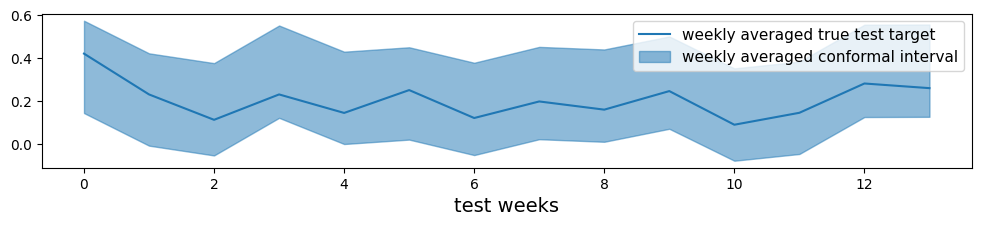

In [27]:
def weekly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)

weekly_avg_test = weekly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weekly_avg(y_test.values), label = "weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weekly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")